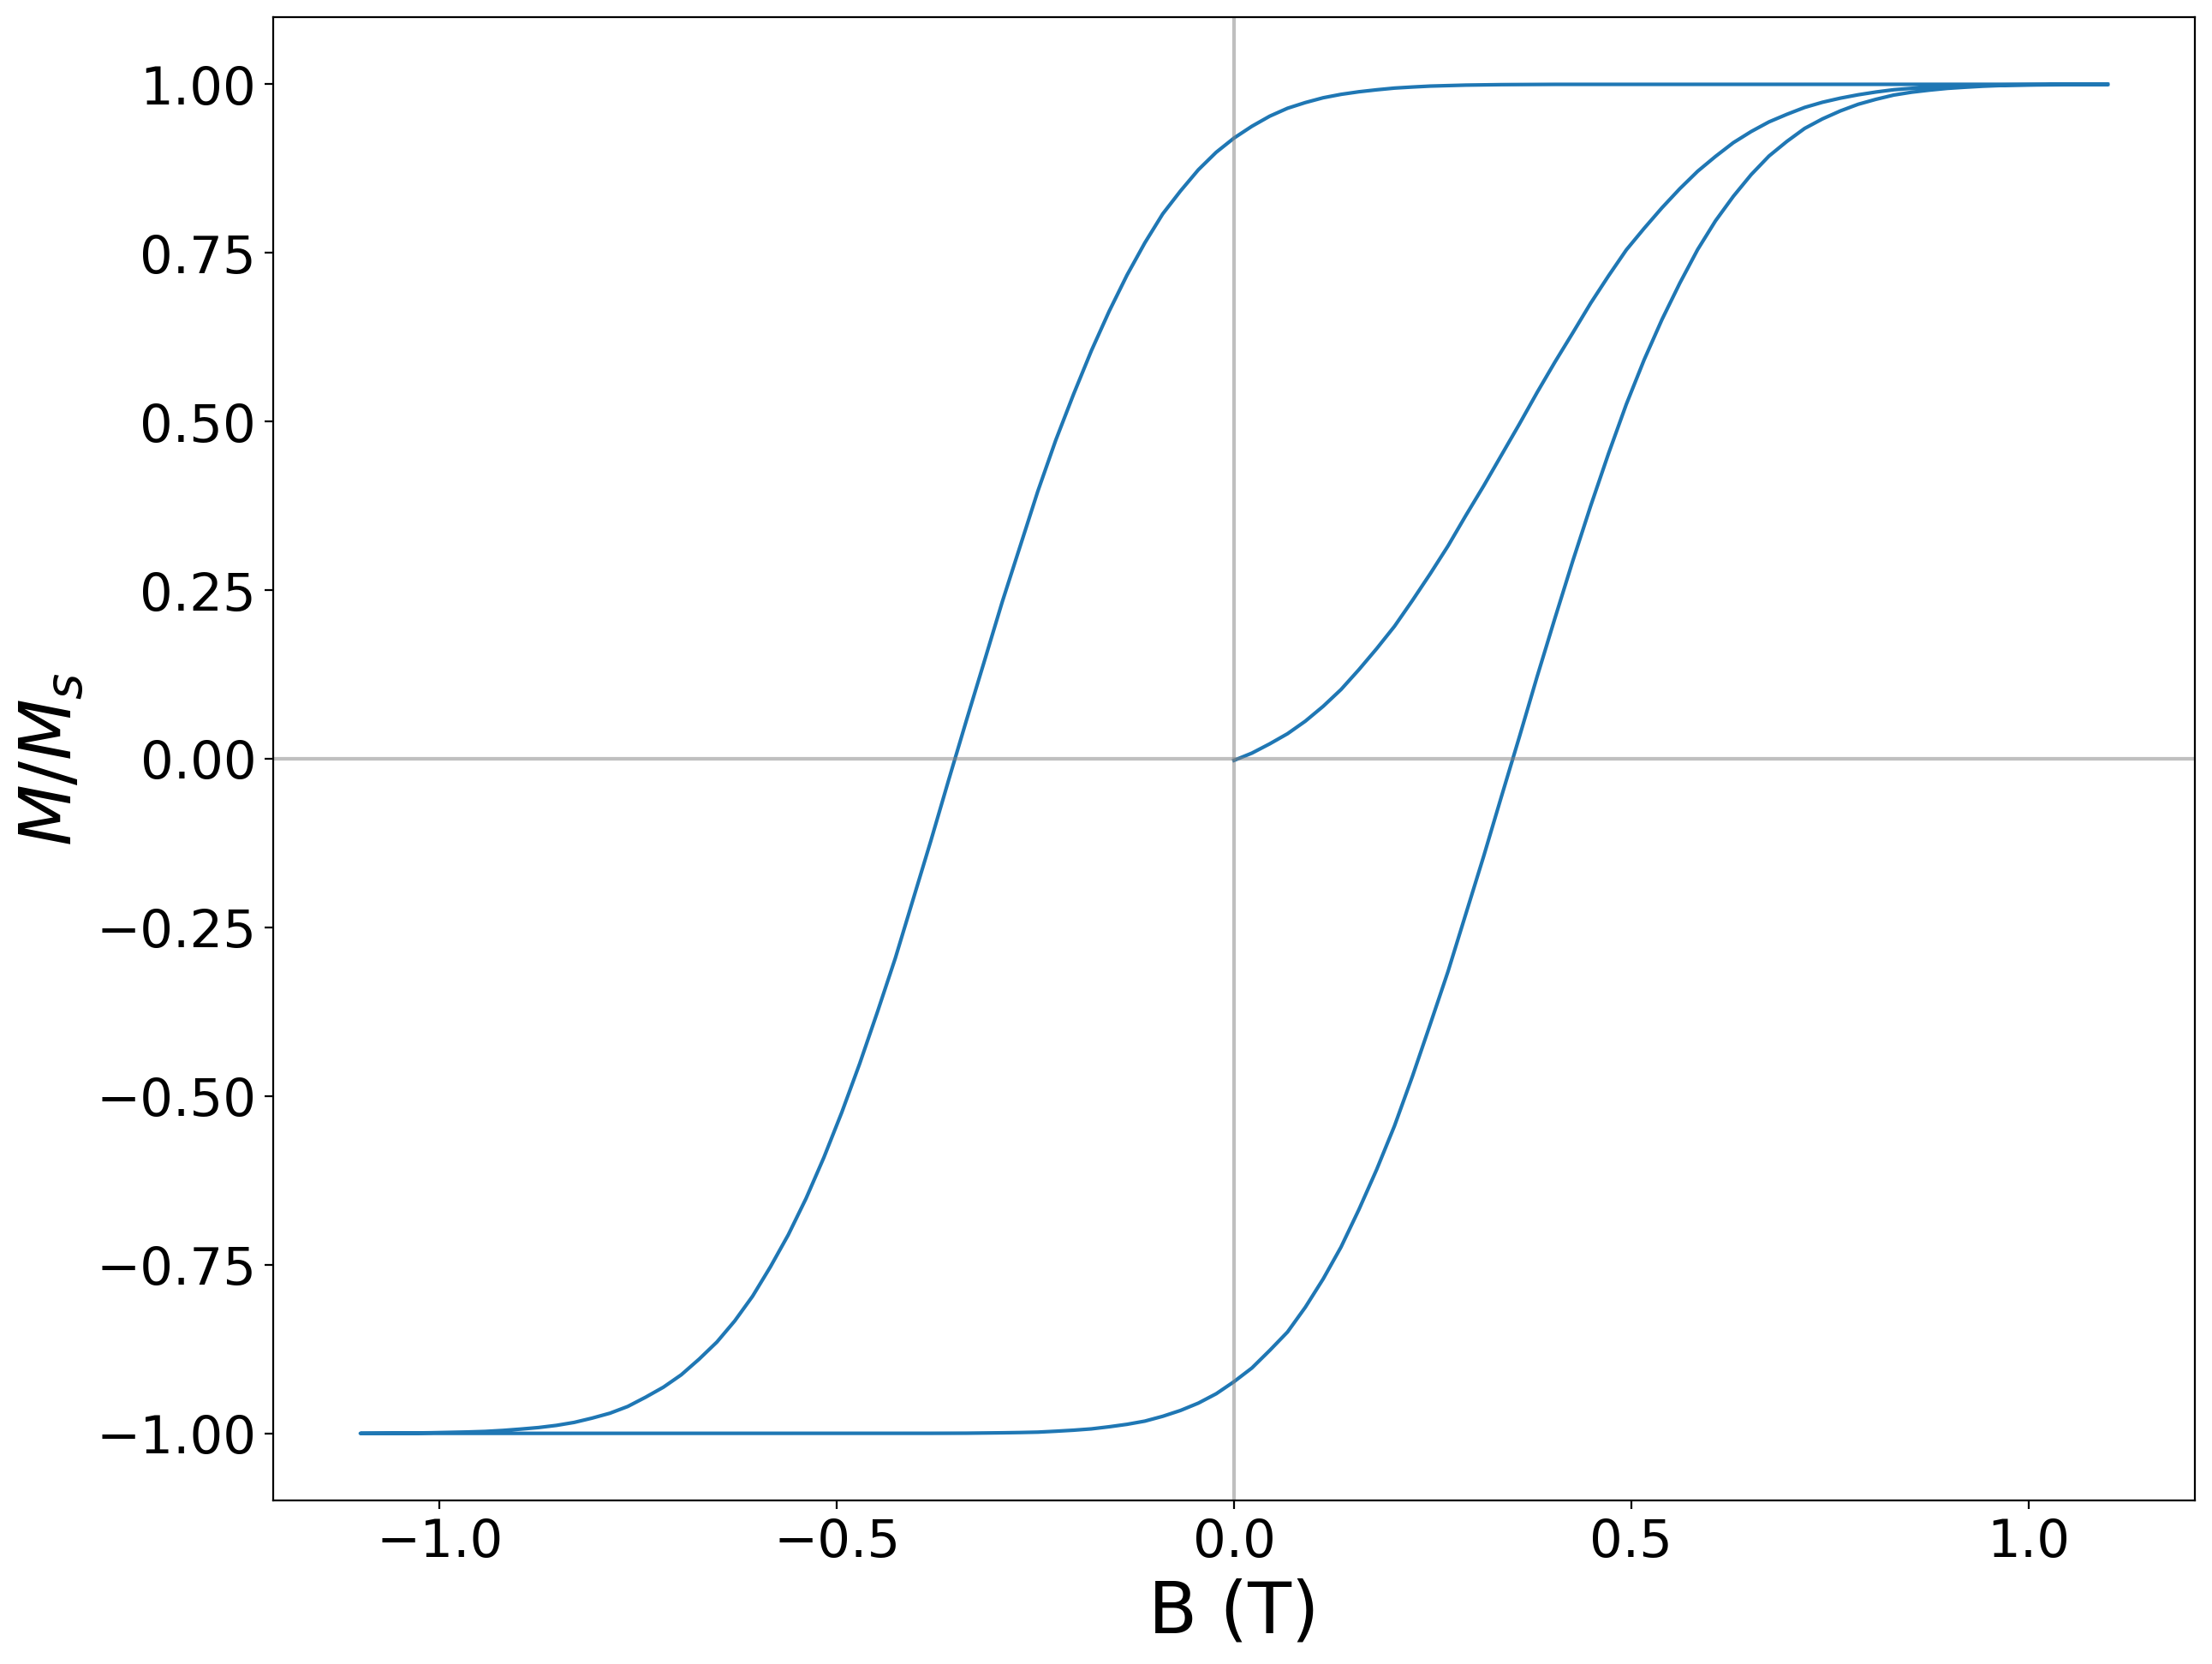

In [10]:
#2024-12-13 David Marchfield. making a ferromagnetic hysteresis figure using the Preisach model of hysteresis

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import mre.analyze
#make a class of relays, instantiate some number of them, use numpy.random to generate the values of alpha and beta (the flipping fields), and then plot the resulting hysteresis (summing the states of the relays, and normalizing the sum)
#alternative to the class is to just have arrays. an array of relay states, an array of relay alphas and betas. might be faster than instantiating so many objects... but i'll try this and see how it works as I scale up the number of relays, and do the array approach if i need to later
class Relay(object):
    def __init__(self,state,weight,alpha,beta):
        """State can only be 1 or 0, alpha must be [-1,0), beta (0,+1]"""
        self.state = state
        self.weight = weight
        self.alpha = alpha
        self.beta = beta
    
    def get_state(self):
        return self.state*self.weight

    def update_state(self,field):
        self.state[np.greater_equal(field,self.beta)] = 1
        self.state[np.less_equal(field,self.alpha)] = 0

    def get_weights(self):
        return self.weight


def generate_relays(num_relays:int,distribution='uniform'):
    if distribution == 'uniform':
        alpha = np.random.uniform(low=-1.0,high=0.0,size=num_relays)
        beta = np.random.uniform(low=-1.0,high=0.0,size=num_relays)*-1
        rng = np.random.default_rng()
        state = rng.integers(0,1,size=num_relays,endpoint=True)
        weight = np.random.uniform(low=1.0,high=5.0,size=num_relays)
    elif distribution == 'normal':
        rng = np.random.default_rng()
        alpha = np.random.normal(loc=-0.35,scale=0.2,size=num_relays)
        beta = np.random.normal(loc=0.35,scale=0.2,size=num_relays)
        state = rng.integers(0,1,size=num_relays,endpoint=True)
        weight = np.random.normal(loc=5.0,scale=2.5,size=num_relays)
        weight = np.clip(weight,a_min=0.01,a_max=None)

    relays = Relay(state,weight,alpha,beta)
    return relays

field_series = np.linspace(0,1.1,num=50)
# print(field_series)
field_series = np.concatenate((field_series,field_series[-2::-1],-1*field_series[1::],-1*field_series[-2::-1],field_series[1::]))
# print(field_series)

num_relays_list = [20,100,1e5]
num_relays_list =[1e5]

fig, ax = plt.subplots(layout='constrained')
default_width,default_height = fig.get_size_inches()
fig.set_size_inches(2*default_width,2*default_height)
fig.set_dpi(200)

for num_relays in num_relays_list:
    num_relays =int(num_relays)
    relays = generate_relays(num_relays,distribution='normal')

    sum_results = np.zeros((field_series.shape[0],))
    
    for i, field in enumerate(field_series):
        relays.update_state(field)
        sum_results[i] = 2*((np.sum((relays.get_state()))/np.sum(relays.get_weights())) - 0.5)
    # ax.plot(field_series,sum_results,label=f'N={num_relays}')
    ax.plot(field_series,sum_results)
ax.set_xlabel('B (T)')
ax.set_ylabel('$M/M_s$')
# ax.legend()
ax.axhline(0,0,1,color='gray',alpha=0.5)
ax.axvline(0,0,1,color='gray',alpha=0.5)
mre.analyze.format_figure(ax)
output_dir = '/mnt/c/Users/bagaw/Desktop/dissertation_figures/'
savename = output_dir + 'preisach_model.png'
plt.savefig(savename)
plt.show()
